In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

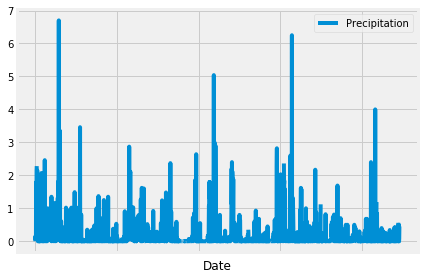

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print(latest_date)
# latest date is 2017-08-23
date_one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
# print(date_one_year_ago)
# Date one year ago is 2016-08-23


# Perform a query to retrieve the data and precipitation scores

prcp_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >='2016-08-23').order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
 
prcp_df = pd.DataFrame(prcp_query, columns = ['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace = True)

# Sort the dataframe by date

prcp_df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot.line()
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [24]:
# Design a query to show how many stations are available in this dataset?
# session.query(Station).first().__dict__

session.query(func.count(distinct(Station.station))).one()

(9)

In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?

waihee_temps = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),\
    func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(Measurement.station == "USC00519281").all()
waihee_temps

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120d8bb00>]],
      dtype=object)

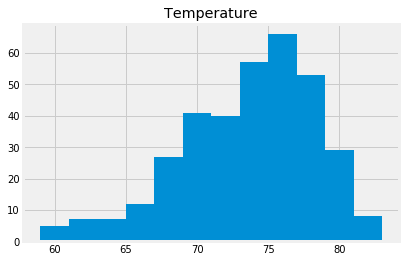

In [44]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

waihee_temp = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= "2016-08-23").all()

waihee_df = pd.DataFrame(waihee_temp, columns=['Temperature'])
waihee_df.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [62]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def cal_temps(start,end):
    sel = [func.avg(Measurement.tobs), \
           func.max(Measurement.tobs), \
           func.min(Measurement.tobs)]
    calcs = session.query(*sel).filter(func.strftime('%Y-%m-%d', Measurement.date)\
            .between('2016-12-20','2017-01-07')).one()
    return calcs

vacation_temps = cal_temps('2016-12-20','2017-01-07')
vacation_avg = vacation_temps[0]
vacataion_max = vacation_temps[1]
vacation_min = vacation_temps[2]
len(vacation_temps)
vacation_temps

(70.85593220338983, 78.0, 62.0)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


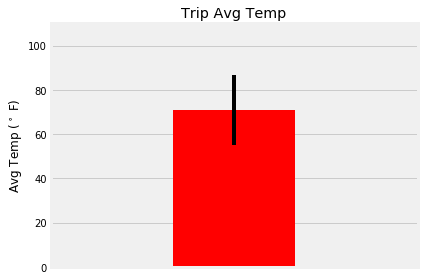

In [66]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar( 1,vacation_avg, color = 'red', yerr = vacataion_max-vacation_min, align='center')
plt.xlim(-0.2, 2.2)
plt.ylim([0, 110])
plt.axes().get_xaxis().set_visible(False)
plt.title('Trip Avg Temp')
plt.ylabel("Avg Temp ($^\circ$ F)")
plt.tight_layout()
plt.show()